Simply debias BERT by optimizing the log odds ratio

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
from overrides import overrides
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

In [4]:
lr = 5e-5
weight_reg = 1e-4
train_file = "gender_occ_pos_w_probs_train.txt"
val_file = "gender_occ_pos_w_probs_val.txt"

In [5]:
# Parameters
train_file = "gender_emo_w_probs_train.txt"
val_file = "gender_emo_w_probs_val.txt"
lr = 1e-05


In [6]:
from bert_utils import Config, BertPreprocessor
config = Config(
    model_type="bert-base-uncased",
    max_seq_len=24,
    batch_size=32,
    bias_weight=1., # technically unnecessary, but for easier debugging
    consistency_weight=1.,
    lr=lr,
    weight_reg=weight_reg,
    disable_dropout=True,
    init_probs_precomputed=True,
    testing=True,
    remove_prior_bias=True,
    epochs=3,
    train_file=train_file,
    val_file=val_file,
)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
T = TypeVar("T")
TensorDict = Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]]

In [9]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [10]:
DATA_ROOT = Path("../data")
MODEL_SAVE_DIR = Path("../weights")

Read the model in here

In [11]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
masked_lm = BertForMaskedLM.from_pretrained(config.model_type)
masked_lm.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
       

Dropout might be causing the model to be more uncertain, attributing lower probs to the correct sentence: disabling might help with logit explosion

In [12]:
if config.disable_dropout:
    def disable_dropout(mod):
        if hasattr(mod, "named_children"):
            for nm, child in mod.named_children():
                if "dropout" in nm: child.p = 0. # forcibly set to 0
                disable_dropout(child)
    disable_dropout(masked_lm)

In [13]:
masked_lm

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.0)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.0)
            )
          )
          (intermediate): BertIntermediate(
       

Freeze positional embeddings

In [14]:
masked_lm.bert.embeddings.position_embeddings.requires_grad = False
masked_lm.bert.embeddings.token_type_embeddings.requires_grad = False

Freeze layer norm

In [15]:
for k, v in masked_lm.named_parameters():
    if "LayerNorm" in k: v.requires_grad = False

# The Dataset

In [16]:
from allennlp.data.token_indexers import PretrainedBertIndexer

def flatten(x: List[List[T]]) -> List[T]:
        return [item for sublist in x for item in sublist]

token_indexer = PretrainedBertIndexer(
    pretrained_model=config.model_type,
    max_pieces=config.max_seq_len,
    do_lowercase=True,
 )

def tokenizer(s: str):
    maxlen = config.max_seq_len - 2
    toks = token_indexer.wordpiece_tokenizer(s)[:maxlen]
    return toks

In [17]:
def to_np(t): return t.detach().cpu().numpy()

def to_words(arr):
    if len(arr.shape) > 1:
        return [to_words(a) for a in arr]
    else:
        arr = to_np(arr)
        return " ".join([itot(i) for i in arr])

In [18]:
rev_vocab = {v: k for k, v in token_indexer.vocab.items()}

def ttoi(t: str): return token_indexer.vocab[t]
def itot(i: int): return rev_vocab[i]

In [19]:
from allennlp.data.vocabulary import Vocabulary
global_vocab = Vocabulary()

### Dataset

In [20]:
import csv
from allennlp.data import DatasetReader, Instance, Token
from allennlp.data.fields import (TextField, SequenceLabelField, LabelField, 
                                  MetadataField, ArrayField)

class BertTextField(TextField):
    @overrides
    def get_padding_lengths(self): # consistent padding lengths
        pad_lengths = super().get_padding_lengths()
        for k in pad_lengths.keys():
            pad_lengths[k] = config.max_seq_len
        return pad_lengths

class LongArrayField(ArrayField):
    @overrides
    def as_tensor(self, padding_lengths: Dict[str, int]) -> torch.Tensor:
        tensor = torch.from_numpy(self.array)
        return tensor
    
class FloatArrayField(ArrayField):
    @overrides
    def as_tensor(self, padding_lengths: Dict[str, int]) -> torch.FloatTensor:
        tensor = torch.FloatTensor(self.array)
        return tensor

class DebiasingDatasetReader(DatasetReader):
    def __init__(self, tokenizer, token_indexers, 
                 init_probs_precomputed: bool=False,
                 remove_prior_bias: bool=False,
                 ) -> None:
        super().__init__(lazy=False)
        self.tokenizer = tokenizer
        self.token_indexers = token_indexers
        self.vocab = token_indexers["tokens"].vocab
        self._init_probs_precomputed = init_probs_precomputed
        self._remove_prior_bias = remove_prior_bias

    def _proc(self, x):
        if x == "[MASK]" or x == "[PAD]": return x
        else: return x.lower()
        
    @overrides
    def text_to_instance(self, tokens: List[str], w1: str, w2: str, 
                         p1: Optional[float], p2: Optional[float],
                         desired_bias: Optional[float],
                        ) -> Instance:
        fields = {}
        input_toks = [Token(self._proc(x)) for x in tokens]
        fields["input"] = BertTextField(input_toks, self.token_indexers)        
        # take [CLS] token into account
        mask_position = tokens.index("[MASK]") + 1
        fields["mask_positions"] = LongArrayField(
            np.array(mask_position, dtype=np.int64),
         )
        fields["target_ids"] = LongArrayField(np.array([
            self.vocab[w1], self.vocab[w2],
        ], dtype=np.int64))
                
        if self._init_probs_precomputed:
            fields["initial_prob_sum"] = FloatArrayField(np.array(p1 + p2, dtype=np.float32))
        else:
            with torch.no_grad():
                bert_input = (self.token_indexers["tokens"]
                              .tokens_to_indices(input_toks, global_vocab, "tokens"))
                token_ids = torch.LongTensor(bert_input["tokens"]).unsqueeze(0)
                probs = masked_lm(token_ids)[0, mask_position, :].detach().numpy()
                probs = (probs - probs.max())
                probs = probs.exp() / probs.exp().sum()
                fields["initial_prob_sum"] = \
                    FloatArrayField(np.array(probs[self.vocab[w1]] + probs[self.vocab[w2]],
                               dtype=np.float32))
            
        if self._remove_prior_bias:
            fields["desired_bias"] = \
                FloatArrayField(np.array(desired_bias, dtype=np.float32))
        
        return Instance(fields)
    
    @overrides
    def _read(self, file_path: str) -> Iterator[Instance]:
        p1, p2 = 0., 0.
        with open(file_path, "rt") as f:
            reader = csv.reader(f)
            next(reader) # skip header
            for row in reader:
                if self._init_probs_precomputed: 
                    sentence, w1, w2, tgt, p1, p2, prior_bias, bias_score = row
                else: sentence, w1, w2, tgt = row
                yield self.text_to_instance(
                    self.tokenizer(sentence), 
                    w1, w2, # words
                    float(p1), float(p2), # initial probs
                    float(prior_bias), # prior bias
                )

In [21]:
reader = DebiasingDatasetReader(tokenizer=tokenizer, 
                                token_indexers={"tokens": token_indexer},
                                init_probs_precomputed=config.init_probs_precomputed,
                                remove_prior_bias=config.remove_prior_bias)
train_ds, val_ds = (reader.read(DATA_ROOT / fname) for fname in [config.train_file, config.val_file])

0it [00:00, ?it/s]

864it [00:00, 19757.49it/s]


0it [00:00, ?it/s]

96it [00:00, 16045.16it/s]

In [22]:
vars(train_ds[0].fields["input"])

{'tokens': [[MASK], feels, angry],
 '_token_indexers': {'tokens': <allennlp.data.token_indexers.wordpiece_indexer.PretrainedBertIndexer at 0x1a31ef9c50>},
 '_indexed_tokens': None,
 '_indexer_name_to_indexed_token': None}

### Data Iterator

In [23]:
from allennlp.data.iterators import BasicIterator

iterator = BasicIterator(
        batch_size=config.batch_size, 
    )
iterator.index_with(global_vocab)

Sanity check

In [24]:
batch = next(iter(iterator(train_ds)))

In [25]:
batch

{'input': {'tokens': tensor([[  101,  1031, 16814, 29636,  3663,  3084,   103,  2514, 13736,   102,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2081,  2033,  2514, 11654,   102,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  5683, 10215,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  5683,  7653,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,  1031, 16814, 29636,  2081,   103,  2514,  9943,   102,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

# Model and Loss

### The loss function

In [26]:
def mse_loss(x, y, desired=0): return ((x - y - desired) ** 2).mean()
def mae_loss(x, y, desired=0): return (x - y - desired).abs().mean()
class HingeLoss(nn.Module):
    def __init__(self, margin: float=0.1):
        super().__init__()
        self.margin = margin
    def forward(self, x, y, desired=0.):
        return torch.relu((x - y - desired).abs().mean() - self.margin)

In [27]:
def neg_likelihood(ll, # (batch, )
               initial_prob_sum, # (batch, )
     ):
    """log likelihood of either of the target ids being chosen"""
    return -ll.mean()

class LogitConsistency(nn.Module):
    def __init__(self, distance: Callable):
        super().__init__()
        self._distance = distance
    
    def forward(self, ll, # (batch, )
                initial_prob_sum, # (batch, )
               ):
        """
        Constrains prob sum put on two words to be roughly equal
        TODO: Provide some probabilistic/statistical interpretation
        """
        d = self._distance(ll, initial_prob_sum.log())
        return d

In [28]:
from allennlp.training.metrics import Metric
class TotalProbDiff(Metric):
    def __init__(self):
        super().__init__()
        self._total = 0
        self._n_obs = 0
        
    def __call__(self, ll, initial_prob_sum):
        self._total += (ll.exp() - initial_prob_sum).mean().item()
        self._n_obs += 1
        
    def get_metric(self, reset: bool=False):
        mtrc = self._total / self._n_obs
        if reset: self.reset()
        return mtrc
    
    def reset(self):
        self._total = 0
        self._n_obs = 0

In [29]:
class BiasLoss(nn.Module):
    """
    Returns the deviation of the log odds ratio from its desired value.
    Denoting the probs as p and q there are several options available:
        - MSE(log p, log q)
        - Max-margin loss
    Most processing takes place here because there is a lot of shared heavy processing required
    (e.g. computing partition function)
    TODO: Add option to set the optimal log odds ratio
    TODO: Ensure the logits do not change significantly
    """
    def __init__(self, loss_func: Callable=mae_loss,
                 consistency_loss_func: Callable=LogitConsistency(mae_loss),
                 bias_weight: float=1.,
                 consistency_weight: float=1.):
        super().__init__()
        self.loss_func = loss_func
        self._consistency_loss = consistency_loss_func
        self.consistency_weight = consistency_weight
        self.bias_weight = bias_weight
        self._total_prob_diff = TotalProbDiff()
    
    @staticmethod
    def _log_likelihood(logits, # (batch, V)
                        target_logits, # (batch, )
                       ) -> torch.FloatTensor: # (batch, )
        max_logits = logits.max(1, keepdim=True)[0] # (batch, )
        log_exp_sum_logits = ((logits - max_logits).exp()
                              .sum(1).log()) # (batch, )
        # these logits should never be masked
        log_exp_sum_correct_logits = ((target_logits - max_logits).exp()
                                      .sum(1).log()) # (batch, )
        return log_exp_sum_correct_logits - log_exp_sum_logits
        
    def forward(self, logits: torch.FloatTensor, # (batch, seq, V)
                mask_positions: torch.LongTensor, # (batch, )
                target_ids: torch.LongTensor, # (batch, 2)
                initial_prob_sum: torch.FloatTensor, # (batch, )
                desired_bias: torch.FloatTensor=None,
               ) -> torch.FloatTensor:
        """
        input_ids: Numericalized tokens
        mask_position: Positions of mask tokens
        target_ids: Ids of target tokens to compute log odds on
        padding_mask: padding positions
        """
        bs, seq = logits.size(0), logits.size(1)

        # Gather the logits for at the masked positions
        # TODO: More efficient implementation?
        # Gather copies the data to create a new tensor which we would rather avoid
        sel = (mask_positions.unsqueeze(1)
                .unsqueeze(2).expand(bs, 1, logits.size(2))) # (batch, 1, V)
        logits_at_masked_positions = logits.gather(1, sel).squeeze(1) # (batch, V)
        
        # Gather the logits for the target ids
        sel = target_ids
        target_logits_at_masked_positions = logits_at_masked_positions.gather(1, sel).squeeze(1) # (batch, 2)
        
        bias_loss = self.loss_func(
            target_logits_at_masked_positions[:, 0], # male logits
            target_logits_at_masked_positions[:, 1], # female logits
            desired=desired_bias if desired_bias is not None else 0.,
         )
        
        # compute log likelihood of either of the target ids being observed
        ll = self._log_likelihood(logits_at_masked_positions,
                                  target_logits_at_masked_positions)
        
        # enforce consistency between prior probabilities and current probabilities
        consistency_loss = self._consistency_loss(
            ll, initial_prob_sum,
         )
        out_dict = {}
        out_dict["bias_loss"] = bias_loss * self.bias_weight
        out_dict["consistency_loss"] = consistency_loss * self.consistency_weight
        out_dict["loss"] = out_dict["bias_loss"] + out_dict["consistency_loss"]
        out_dict["total_prob_diff"] = self._total_prob_diff(ll, initial_prob_sum)
        return out_dict

    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        return {"total_prob_diff": self._total_prob_diff.get_metric(reset)}

Sanity checks

In [30]:
to_words(batch["input"]["tokens"])

['[CLS] [ ##unk ##] situation makes [MASK] feel miserable [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] made me feel annoyed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] feels terrified [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] feels relieved [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [ ##unk ##] made [MASK] feel furious [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] feels depressed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] made me feel angry [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [31]:
batch

{'input': {'tokens': tensor([[  101,  1031, 16814, 29636,  3663,  3084,   103,  2514, 13736,   102,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  2081,  2033,  2514, 11654,   102,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  5683, 10215,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,   103,  5683,  7653,   102,     0,     0,     0,     0,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
               0,     0,     0,     0],
          [  101,  1031, 16814, 29636,  2081,   103,  2514,  9943,   102,     0,
               0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           

In [32]:
bias_loss = BiasLoss()
logits = masked_lm(batch["input"]["tokens"])
bias_loss(logits, batch["mask_positions"], batch["target_ids"],
          batch["initial_prob_sum"])

{'bias_loss': tensor(0.6573, grad_fn=<MulBackward0>),
 'consistency_loss': tensor(2.5011e-06, grad_fn=<MulBackward0>),
 'loss': tensor(0.6573, grad_fn=<AddBackward0>),
 'total_prob_diff': None}

In [33]:
probs = torch.softmax(logits[:, 1, :], 1)

In [34]:
sentence, w1, w2 = "[MASK] is a nurse", "he", "she"

tokens = tokenizer(sentence)
mask_position = tokens.index("[MASK]") + 1
input_toks = [Token(w) for w in tokens]
bert_input = (token_indexer.tokens_to_indices(input_toks, global_vocab, "tokens"))
token_ids = torch.LongTensor(bert_input["tokens"]).unsqueeze(0)

In [35]:
probs[:, token_indexer.vocab[w1]] + probs[:, token_indexer.vocab[w2]]

tensor([0.0011, 0.2131, 0.7464, 0.8567, 0.0028, 0.8296, 0.1226, 0.0905, 0.1095,
        0.0027, 0.0026, 0.0021, 0.0933, 0.1105, 0.0933, 0.0012, 0.1598, 0.0013,
        0.0933, 0.2126, 0.2638, 0.0028, 0.0012, 0.8455, 0.5346, 0.2476, 0.0011,
        0.6875, 0.8472, 0.0012, 0.8296, 0.2126], grad_fn=<AddBackward0>)

In [36]:
batch["initial_prob_sum"]

tensor([8.6004e-05, 1.5584e-05, 1.7052e-05, 1.9366e-04, 5.0826e-04, 2.4068e-05,
        1.4845e-04, 8.1975e-06, 5.1509e-06, 4.8074e-04, 4.0914e-05, 5.5844e-04,
        8.1894e-06, 1.1251e-05, 9.6419e-06, 1.0339e-03, 2.9403e-05, 2.6314e-05,
        7.9557e-06, 8.9427e-06, 2.6384e-01, 2.5408e-05, 1.8579e-06, 8.4551e-01,
        1.9792e-05, 1.0239e-05, 1.1893e-04, 3.7665e-05, 2.5339e-04, 8.0187e-06,
        4.6556e-05, 6.2406e-06])

### The allennlp model (for training)

In [37]:
from copy import deepcopy

In [38]:
from allennlp.models import Model

class BERT(Model):
    def __init__(self, vocab, bert_for_masked_lm, 
                 loss: nn.Module=BiasLoss()):
        super().__init__(vocab)
        self.bert_for_masked_lm = bert_for_masked_lm
        self.loss = loss
    
    def forward(self, 
                input: TensorDict,
                mask_positions: torch.LongTensor,
                target_ids: torch.LongTensor,
                initial_prob_sum: torch.FloatTensor,
                desired_bias: torch.FloatTensor=None,
            ) -> TensorDict:
        logits = self.bert_for_masked_lm(input["tokens"])
        # most of processing takes place in loss func
        out_dict = self.loss(logits, mask_positions, 
                             target_ids, initial_prob_sum,
                             desired_bias=desired_bias,
                            )
        out_dict["logits"] = logits
        return out_dict
    
    def get_metrics(self, reset: bool=False):
        return self.loss.get_metrics()

In [39]:
logit_distance = mae_loss

loss = BiasLoss(
    loss_func=logit_distance,
    consistency_loss_func=LogitConsistency(logit_distance),
    bias_weight=config.bias_weight,
    consistency_weight=config.consistency_weight,
)
model = BERT(global_vocab, masked_lm, loss=loss)

In [40]:
init_dict = dict(model.state_dict())

In [41]:
model.load_state_dict(init_dict)

In [42]:
orig_weights = {k: deepcopy(v) for k, v in model.named_parameters()}

### Bias scores before

In [43]:
masked_lm.eval()
logits = masked_lm(processor.to_bert_model_input("[MASK] is a housemaid"))[0, 1]

In [44]:
logits[ttoi("he")]

tensor(8.1598, grad_fn=<SelectBackward>)

In [45]:
logits[ttoi("she")]

tensor(8.8144, grad_fn=<SelectBackward>)

In [46]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [47]:
probs[ttoi("he")]

tensor(0.2187, grad_fn=<SelectBackward>)

In [48]:
probs[ttoi("she")]

tensor(0.4208, grad_fn=<SelectBackward>)

For word not in vocab

In [49]:
logits = masked_lm(processor.to_bert_model_input("[MASK] is a slut"))[0, 1]

In [50]:
logits[ttoi("he")]

tensor(7.7761, grad_fn=<SelectBackward>)

In [51]:
logits[ttoi("she")]

tensor(8.8424, grad_fn=<SelectBackward>)

In [52]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [53]:
probs[ttoi("he")]

tensor(0.1566, grad_fn=<SelectBackward>)

In [54]:
probs[ttoi("she")]

tensor(0.4547, grad_fn=<SelectBackward>)

### Probability distribution for unrelated sentence

In [55]:
def print_topk_preds(masked_sentence, k=5, strlen=30):
    mask_idx = [x.text for x in processor.tokenize(masked_sentence)].index("[MASK]") + 1
    logits = masked_lm(processor.to_bert_model_input(masked_sentence))
    probs = torch.softmax(logits.squeeze(0), 1)
    topk = []
    for p, id_ in zip(*probs[mask_idx, :].topk(k)):
        topk.append(("%.4f" % p.item(), itot(id_.item())))
    print("\n".join([f"{masked_sentence.replace('[MASK]', w)}:{' ' * (strlen - len(w) - len(p))}{p}" for p, w in topk]))

In [56]:
print_topk_preds("i ride my [MASK] to work")

i ride my bike to work:                    0.6130
i ride my motorcycle to work:              0.0891
i ride my car to work:                     0.0659
i ride my bus to work:                     0.0620
i ride my bicycle to work:                 0.0207


In [57]:
print_topk_preds("the [MASK] wagged its tail")

the dog wagged its tail:                     0.3024
the cat wagged its tail:                     0.0879
the bird wagged its tail:                    0.0463
the wolf wagged its tail:                    0.0325
the creature wagged its tail:                0.0312


In [58]:
print_topk_preds("the fish [MASK] through the water")

the fish swam through the water:                    0.1042
the fish flew through the water:                    0.0561
the fish sailed through the water:                  0.0507
the fish ran through the water:                     0.0467
the fish raced through the water:                   0.0463


# Confirming Bias Scores Before

### Train

In [59]:
def compute_bias_score(row):
    sentence, fword, mword, prior_bias = [row[k] for k in ["sentence", "fword", "mword", "prior_bias"]]
    mask_pos = tokenizer(sentence).index("[MASK]") + 1
    logits = masked_lm(processor.to_bert_model_input(sentence)).squeeze(0)
    i1,i2 = ttoi(fword),ttoi(mword)
    log_odds = logits[mask_pos, i1] - logits[mask_pos, i2]
    bias_correction = prior_bias
    return (log_odds - bias_correction).item()

In [60]:
df_train = pd.read_csv(DATA_ROOT / config.train_file)

(array([ 17.,  17.,  39.,  73., 138., 191., 217., 123.,  31.,  18.]),
 array([-2.60324973, -2.15702654, -1.71080334, -1.26458015, -0.81835696,
        -0.37213376,  0.07408943,  0.52031263,  0.96653582,  1.41275901,
         1.85898221]),
 <a list of 10 Patch objects>)

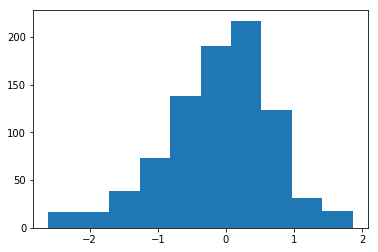

In [61]:
plt.hist(df_train["original_bias_score"])

### Dev

In [62]:
df_val = pd.read_csv(DATA_ROOT / config.val_file)

(array([ 1.,  2.,  3.,  1., 12., 14., 31., 21.,  5.,  6.]),
 array([-2.75335377, -2.32684494, -1.9003361 , -1.47382726, -1.04731842,
        -0.62080958, -0.19430075,  0.23220809,  0.65871693,  1.08522577,
         1.5117346 ]),
 <a list of 10 Patch objects>)

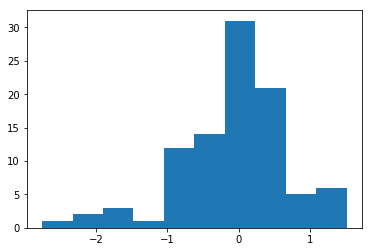

In [63]:
plt.hist(df_val["original_bias_score"])

# Training Loop

In [64]:
from allennlp.training import Callback

In [65]:
from copy import deepcopy

class StatisticRecorder(Callback):
    def __init__(self, orig_weights, rec_periods=1):
        self.rec_periods = rec_periods
        self.norms = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        self.grad_magnitudes = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        self._orig_weights = orig_weights
        self.change_magnitudes = {k: [] for k, v in model.named_parameters() if v.requires_grad}
        
    def on_batch_end(self, data):
        if (data['batches_this_epoch'] + 1) % self.rec_periods == 0:
            with torch.no_grad():
                for k, p in self.trainer.model.named_parameters():
                    if p.requires_grad and p.grad is not None:
                        Z = torch.norm(p).item()
                        self.norms[k].append(Z)
                        self.grad_magnitudes[k].append((torch.norm(p.grad) / Z).item())
                        self.change_magnitudes[k].append((torch.norm(p - self._orig_weights[k]) / Z).item())

In [66]:
class WeightDeviationRegularizor(Callback):
    def __init__(self, orig_weights, weight=1e-4, l1=True):
        self.orig_weights = orig_weights
        self.weight = weight
        self.l1 = l1
        
    def get_reg_term(self, now, orig):
        if self.l1:
            return torch.where(now < orig, torch.ones_like(now), -torch.ones_like(now))
        else:
            return (orig - now)
        
    def on_backward_end(self, data):
        lr = config.lr
        with torch.no_grad():
            for name, param in self.trainer.model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    reg_term = self.weight * lr * self.get_reg_term(param.data, orig_weights[name])
                    param.data.add_(reg_term)

In [67]:
from collections import defaultdict
class LossMonitor(Callback):
    def __init__(self):
        super().__init__()
        self.logs = defaultdict(list)
    def on_forward_end(self, payload):
        for k, v in payload.items():
            if "loss" in k: self.logs[k].append(v.item())

In [68]:
stat_rec = StatisticRecorder(orig_weights, rec_periods=1)
wdd = WeightDeviationRegularizor(orig_weights, weight=config.weight_reg)
monitor = LossMonitor()

In [69]:
def use(name: str):
    if "LayerNorm" in name: return False
    if "position_embeddings" in name: return False
    if "token_type" in name: return False
    return True

In [70]:
filtered_params = [p for name, p in model.named_parameters() if use(name)]

In [71]:
optimizer = torch.optim.Adam(filtered_params, lr=config.lr, weight_decay=0.)

In [72]:
from allennlp.training.learning_rate_schedulers import SlantedTriangular, CosineWithRestarts
# use slanted triangular lr scheduler to prevent initial spike in consistency loss
lr_sched = SlantedTriangular(optimizer, 
                             num_epochs=config.epochs, 
                             num_steps_per_epoch=iterator.get_num_batches(train_ds))

In [73]:
from allennlp.training import TrainerWithCallbacks

trainer = TrainerWithCallbacks(
    model=model,
    optimizer=optimizer,
    iterator=iterator,
    train_dataset=train_ds,
    validation_dataset=val_ds,
    callbacks=[stat_rec, wdd, monitor],
    learning_rate_scheduler=lr_sched,
    #     serialization_dir=DATA_ROOT / "debias_ckpts",
    cuda_device=0 if torch.cuda.is_available() else -1,
    num_epochs=config.epochs,
)

You provided a validation dataset but patience was set to None, meaning that early stopping is disabled


In [74]:
trainer.train()

  0%|          | 0/27 [00:00<?, ?it/s]

total_prob_diff: 0.0000, loss: 0.7542 ||:   4%|▎         | 1/27 [00:10<04:26, 10.25s/it]

total_prob_diff: 0.0005, loss: 0.7537 ||:   7%|▋         | 2/27 [00:21<04:25, 10.64s/it]

total_prob_diff: -0.0004, loss: 0.7955 ||:  11%|█         | 3/27 [00:29<03:55,  9.81s/it]

total_prob_diff: -0.0002, loss: 0.7939 ||:  15%|█▍        | 4/27 [00:38<03:39,  9.53s/it]

total_prob_diff: -0.0021, loss: 0.8006 ||:  19%|█▊        | 5/27 [00:50<03:43, 10.17s/it]

total_prob_diff: -0.0051, loss: 0.8188 ||:  22%|██▏       | 6/27 [01:02<03:44, 10.71s/it]

total_prob_diff: -0.0044, loss: 0.7928 ||:  26%|██▌       | 7/27 [01:13<03:38, 10.94s/it]

total_prob_diff: -0.0038, loss: 0.7690 ||:  30%|██▉       | 8/27 [01:24<03:29, 11.03s/it]

total_prob_diff: -0.0034, loss: 0.7569 ||:  33%|███▎      | 9/27 [01:36<03:20, 11.12s/it]

total_prob_diff: -0.0028, loss: 0.7353 ||:  37%|███▋      | 10/27 [01:48<03:12, 11.35s/it]

total_prob_diff: -0.0025, loss: 0.7192 ||:  41%|████      | 11/27 [02:00<03:04, 11.54s/it]

total_prob_diff: -0.0024, loss: 0.7116 ||:  44%|████▍     | 12/27 [02:12<02:55, 11.68s/it]

total_prob_diff: -0.0023, loss: 0.7039 ||:  48%|████▊     | 13/27 [02:23<02:44, 11.72s/it]

total_prob_diff: -0.0017, loss: 0.6993 ||:  52%|█████▏    | 14/27 [02:35<02:32, 11.73s/it]

total_prob_diff: -0.0016, loss: 0.6836 ||:  56%|█████▌    | 15/27 [02:47<02:20, 11.71s/it]

total_prob_diff: -0.0014, loss: 0.6814 ||:  59%|█████▉    | 16/27 [02:58<02:08, 11.67s/it]

total_prob_diff: -0.0013, loss: 0.6755 ||:  63%|██████▎   | 17/27 [03:10<01:57, 11.76s/it]

total_prob_diff: 0.0001, loss: 0.6703 ||:  67%|██████▋   | 18/27 [03:22<01:46, 11.83s/it] 

total_prob_diff: 0.0006, loss: 0.6610 ||:  70%|███████   | 19/27 [03:34<01:34, 11.86s/it]

total_prob_diff: 0.0007, loss: 0.6555 ||:  74%|███████▍  | 20/27 [03:46<01:23, 11.87s/it]

total_prob_diff: 0.0007, loss: 0.6501 ||:  78%|███████▊  | 21/27 [03:58<01:10, 11.80s/it]

total_prob_diff: 0.0007, loss: 0.6395 ||:  81%|████████▏ | 22/27 [04:10<00:59, 11.82s/it]

total_prob_diff: 0.0012, loss: 0.6339 ||:  85%|████████▌ | 23/27 [04:21<00:47, 11.75s/it]

total_prob_diff: 0.0011, loss: 0.6249 ||:  89%|████████▉ | 24/27 [04:33<00:35, 11.79s/it]

total_prob_diff: 0.0012, loss: 0.6185 ||:  93%|█████████▎| 25/27 [04:46<00:24, 12.04s/it]

total_prob_diff: 0.0019, loss: 0.6173 ||:  96%|█████████▋| 26/27 [04:58<00:12, 12.22s/it]

total_prob_diff: 0.0022, loss: 0.6137 ||: 100%|██████████| 27/27 [05:10<00:00, 11.98s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

total_prob_diff: 0.0031, loss: 1.0465 ||:  33%|███▎      | 1/3 [00:02<00:04,  2.30s/it]

total_prob_diff: 0.0030, loss: 0.8009 ||:  67%|██████▋   | 2/3 [00:04<00:02,  2.35s/it]

total_prob_diff: 0.0028, loss: 0.6344 ||: 100%|██████████| 3/3 [00:07<00:00,  2.38s/it]


  0%|          | 0/27 [00:00<?, ?it/s]

total_prob_diff: 0.0036, loss: 0.4921 ||:   4%|▎         | 1/27 [00:12<05:33, 12.83s/it]

total_prob_diff: 0.0035, loss: 0.4323 ||:   7%|▋         | 2/27 [00:23<05:07, 12.29s/it]

total_prob_diff: 0.0034, loss: 0.4517 ||:  11%|█         | 3/27 [00:32<04:29, 11.23s/it]

total_prob_diff: 0.0033, loss: 0.4433 ||:  15%|█▍        | 4/27 [00:43<04:13, 11.02s/it]

total_prob_diff: 0.0032, loss: 0.4356 ||:  19%|█▊        | 5/27 [00:54<04:06, 11.21s/it]

total_prob_diff: 0.0031, loss: 0.4269 ||:  22%|██▏       | 6/27 [01:06<03:57, 11.33s/it]

total_prob_diff: 0.0029, loss: 0.4259 ||:  26%|██▌       | 7/27 [01:14<03:27, 10.38s/it]

total_prob_diff: 0.0029, loss: 0.4252 ||:  30%|██▉       | 8/27 [01:21<03:00,  9.49s/it]

total_prob_diff: 0.0029, loss: 0.4169 ||:  33%|███▎      | 9/27 [01:29<02:38,  8.78s/it]

total_prob_diff: 0.0028, loss: 0.4096 ||:  37%|███▋      | 10/27 [01:35<02:17,  8.09s/it]

total_prob_diff: 0.0027, loss: 0.4100 ||:  41%|████      | 11/27 [01:41<02:00,  7.55s/it]

total_prob_diff: 0.0026, loss: 0.4073 ||:  44%|████▍     | 12/27 [01:48<01:47,  7.14s/it]

total_prob_diff: 0.0031, loss: 0.4103 ||:  48%|████▊     | 13/27 [01:54<01:36,  6.87s/it]

total_prob_diff: 0.0031, loss: 0.4048 ||:  52%|█████▏    | 14/27 [02:00<01:26,  6.69s/it]

total_prob_diff: 0.0031, loss: 0.4014 ||:  56%|█████▌    | 15/27 [02:06<01:18,  6.54s/it]

total_prob_diff: 0.0030, loss: 0.3966 ||:  59%|█████▉    | 16/27 [02:13<01:11,  6.47s/it]

total_prob_diff: 0.0032, loss: 0.3959 ||:  63%|██████▎   | 17/27 [02:19<01:04,  6.45s/it]

total_prob_diff: 0.0033, loss: 0.3968 ||:  67%|██████▋   | 18/27 [02:25<00:57,  6.40s/it]

total_prob_diff: 0.0034, loss: 0.3997 ||:  70%|███████   | 19/27 [02:32<00:50,  6.37s/it]

total_prob_diff: 0.0034, loss: 0.3968 ||:  74%|███████▍  | 20/27 [02:38<00:44,  6.36s/it]

total_prob_diff: 0.0034, loss: 0.3929 ||:  78%|███████▊  | 21/27 [02:44<00:38,  6.36s/it]

total_prob_diff: 0.0033, loss: 0.3879 ||:  81%|████████▏ | 22/27 [02:51<00:31,  6.34s/it]

total_prob_diff: 0.0035, loss: 0.3859 ||:  85%|████████▌ | 23/27 [02:57<00:25,  6.34s/it]

total_prob_diff: 0.0034, loss: 0.3838 ||:  89%|████████▉ | 24/27 [03:03<00:19,  6.34s/it]

total_prob_diff: 0.0033, loss: 0.3863 ||:  93%|█████████▎| 25/27 [03:10<00:12,  6.35s/it]

total_prob_diff: 0.0033, loss: 0.3856 ||:  96%|█████████▋| 26/27 [03:16<00:06,  6.35s/it]

total_prob_diff: 0.0032, loss: 0.3827 ||: 100%|██████████| 27/27 [03:22<00:00,  6.34s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

total_prob_diff: 0.0036, loss: 0.9802 ||:  33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

total_prob_diff: 0.0035, loss: 0.6891 ||:  67%|██████▋   | 2/3 [00:02<00:01,  1.25s/it]

total_prob_diff: 0.0034, loss: 0.5191 ||: 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


  0%|          | 0/27 [00:00<?, ?it/s]

total_prob_diff: 0.0034, loss: 0.2487 ||:   4%|▎         | 1/27 [00:07<03:09,  7.28s/it]

total_prob_diff: 0.0034, loss: 0.2950 ||:   7%|▋         | 2/27 [00:13<02:56,  7.05s/it]

total_prob_diff: 0.0034, loss: 0.2901 ||:  11%|█         | 3/27 [00:20<02:44,  6.85s/it]

total_prob_diff: 0.0037, loss: 0.3214 ||:  15%|█▍        | 4/27 [00:26<02:33,  6.69s/it]

total_prob_diff: 0.0037, loss: 0.3074 ||:  19%|█▊        | 5/27 [00:32<02:25,  6.60s/it]

total_prob_diff: 0.0036, loss: 0.3016 ||:  22%|██▏       | 6/27 [00:39<02:16,  6.52s/it]

total_prob_diff: 0.0035, loss: 0.2919 ||:  26%|██▌       | 7/27 [00:45<02:09,  6.46s/it]

total_prob_diff: 0.0034, loss: 0.2830 ||:  30%|██▉       | 8/27 [00:51<02:02,  6.44s/it]

total_prob_diff: 0.0034, loss: 0.2821 ||:  33%|███▎      | 9/27 [00:58<01:55,  6.40s/it]

total_prob_diff: 0.0034, loss: 0.2779 ||:  37%|███▋      | 10/27 [01:04<01:48,  6.38s/it]

total_prob_diff: 0.0033, loss: 0.2755 ||:  41%|████      | 11/27 [01:10<01:41,  6.37s/it]

total_prob_diff: 0.0034, loss: 0.2784 ||:  44%|████▍     | 12/27 [01:17<01:35,  6.35s/it]

total_prob_diff: 0.0034, loss: 0.2798 ||:  48%|████▊     | 13/27 [01:23<01:28,  6.33s/it]

total_prob_diff: 0.0035, loss: 0.2806 ||:  52%|█████▏    | 14/27 [01:29<01:22,  6.32s/it]

total_prob_diff: 0.0035, loss: 0.2774 ||:  56%|█████▌    | 15/27 [01:36<01:15,  6.32s/it]

total_prob_diff: 0.0035, loss: 0.2760 ||:  59%|█████▉    | 16/27 [01:42<01:09,  6.32s/it]

total_prob_diff: 0.0034, loss: 0.2735 ||:  63%|██████▎   | 17/27 [01:48<01:03,  6.32s/it]

total_prob_diff: 0.0034, loss: 0.2729 ||:  67%|██████▋   | 18/27 [01:55<00:56,  6.31s/it]

total_prob_diff: 0.0034, loss: 0.2747 ||:  70%|███████   | 19/27 [02:01<00:50,  6.31s/it]

total_prob_diff: 0.0034, loss: 0.2727 ||:  74%|███████▍  | 20/27 [02:07<00:44,  6.31s/it]

total_prob_diff: 0.0033, loss: 0.2710 ||:  78%|███████▊  | 21/27 [02:14<00:37,  6.33s/it]

total_prob_diff: 0.0032, loss: 0.2701 ||:  81%|████████▏ | 22/27 [02:20<00:31,  6.32s/it]

total_prob_diff: 0.0035, loss: 0.2719 ||:  85%|████████▌ | 23/27 [02:26<00:25,  6.31s/it]

total_prob_diff: 0.0034, loss: 0.2702 ||:  89%|████████▉ | 24/27 [02:33<00:19,  6.40s/it]

total_prob_diff: 0.0034, loss: 0.2693 ||:  93%|█████████▎| 25/27 [02:39<00:12,  6.40s/it]

total_prob_diff: 0.0034, loss: 0.2657 ||:  96%|█████████▋| 26/27 [02:45<00:06,  6.37s/it]

total_prob_diff: 0.0034, loss: 0.2640 ||: 100%|██████████| 27/27 [02:52<00:00,  6.35s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

total_prob_diff: 0.0036, loss: 0.9918 ||:  33%|███▎      | 1/3 [00:01<00:02,  1.28s/it]

total_prob_diff: 0.0035, loss: 0.6447 ||:  67%|██████▋   | 2/3 [00:02<00:01,  1.28s/it]

total_prob_diff: 0.0035, loss: 0.4767 ||: 100%|██████████| 3/3 [00:03<00:00,  1.30s/it]

{'best_epoch': 2,
 'peak_cpu_memory_MB': 3941.736448,
 'training_duration': '00:11:40',
 'training_start_epoch': 0,
 'training_epochs': 2,
 'epoch': 2,
 'training_total_prob_diff': 0.0033594017176778244,
 'training_loss': 0.26403258740901947,
 'training_cpu_memory_MB': 3941.736448,
 'validation_total_prob_diff': 0.003462092622524595,
 'validation_loss': 0.4766666442155838,
 'best_validation_total_prob_diff': 0.003462092622524595,
 'best_validation_loss': 0.4766666442155838}

Analyzing changes

In [75]:
change_sorted_weights = sorted([(-v[-1], k) for k, v in stat_rec.change_magnitudes.items() if len(v) > 0])
{k.replace("bert_for_masked_lm.bert.encoder.", ""): -x for x, k in change_sorted_weights}

{'layer.11.attention.self.value.bias': 0.0014348747208714485,
 'layer.10.attention.output.dense.weight': 0.0012449257774278522,
 'layer.11.intermediate.dense.weight': 0.0012178567703813314,
 'layer.11.attention.output.dense.weight': 0.0011974198278039694,
 'layer.10.intermediate.dense.weight': 0.0011640384327620268,
 'layer.9.attention.output.dense.weight': 0.0011457413202151656,
 'layer.7.attention.output.dense.weight': 0.0011325745144858956,
 'layer.2.attention.output.dense.weight': 0.0011157846311107278,
 'layer.10.attention.self.value.weight': 0.0011144473683089018,
 'layer.8.attention.output.dense.weight': 0.0010877777822315693,
 'layer.11.attention.self.value.weight': 0.0010853117564693093,
 'layer.6.attention.output.dense.weight': 0.0010808364022523165,
 'layer.9.intermediate.dense.weight': 0.0010744750034064054,
 'layer.7.attention.self.value.weight': 0.001072669168934226,
 'layer.9.attention.self.value.weight': 0.0010625360300764441,
 'layer.2.attention.self.value.weight': 0.0

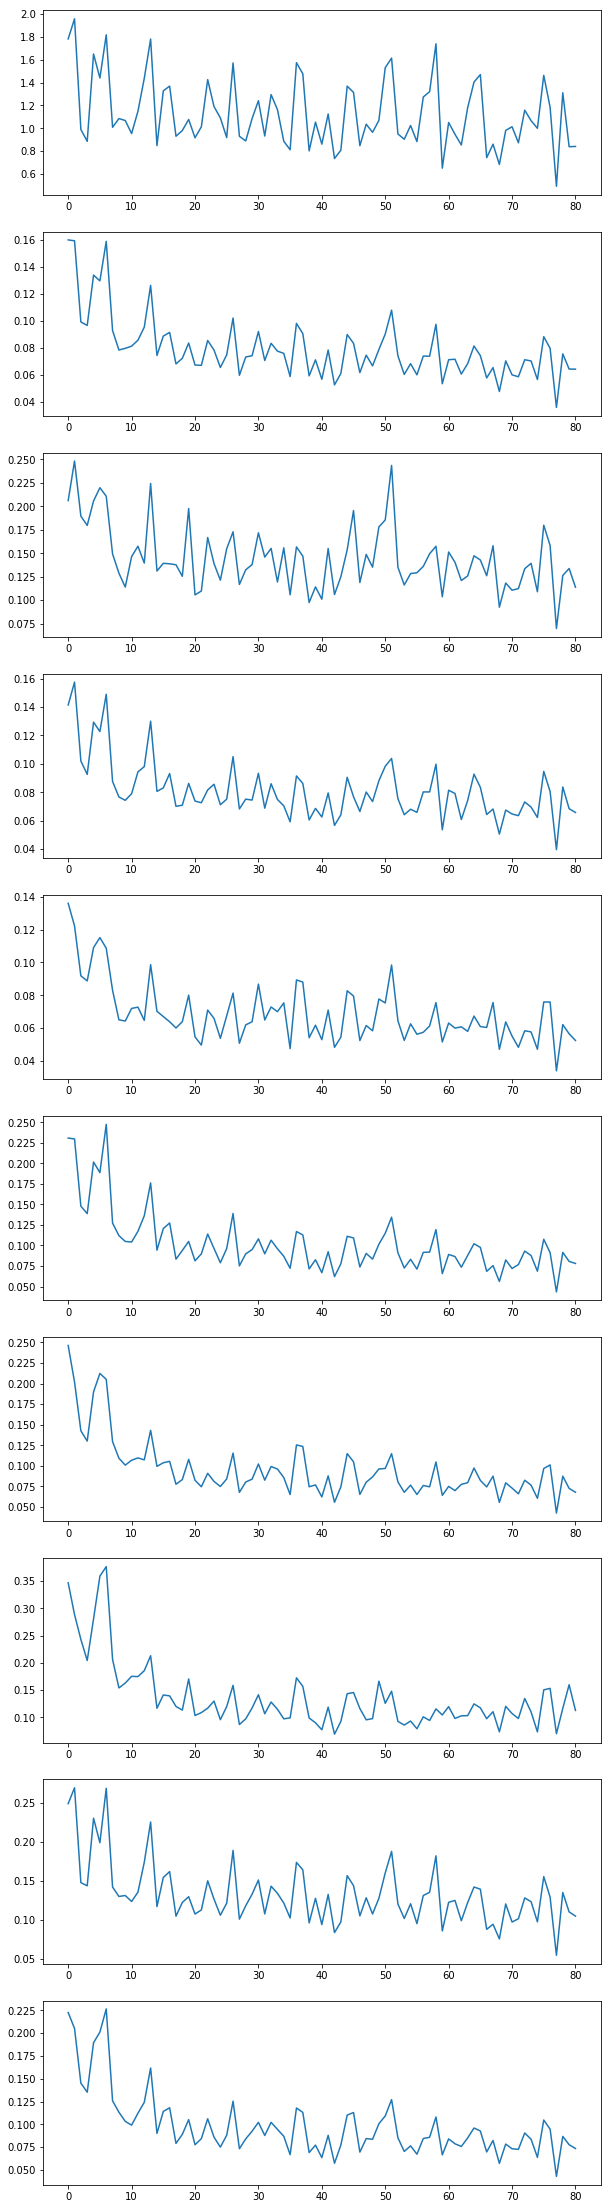

In [76]:
n = 10
fig = plt.figure(figsize=(10, n * 4))
for i, (_, k) in enumerate(change_sorted_weights[:n]):
    ax = fig.add_subplot(n, 1, i+1)
    ax.plot(stat_rec.grad_magnitudes[k])

### Change in loss breakdown

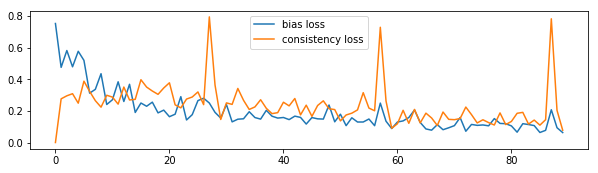

In [77]:
fig = plt.figure(figsize=(10, 30))
ax = fig.add_subplot(n, 1, 1)
ax.plot(monitor.logs["bias_loss"], label="bias loss")
ax.plot(monitor.logs["consistency_loss"], label="consistency loss")
ax.legend()

# Evaluate

Simple prediction

In [78]:
def get_preds(model, batch: TensorDict):
    return model(**batch)["logits"].argmax(2)

In [79]:
to_words(batch["input"]["tokens"])

['[CLS] [ ##unk ##] situation makes [MASK] feel miserable [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] made me feel annoyed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] feels terrified [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] feels relieved [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [ ##unk ##] made [MASK] feel furious [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] feels depressed [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 '[CLS] [MASK] made me feel angry [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [80]:
to_words(get_preds(model, batch))

['. [ the the situation makes me feel . . ∆ ##32 ##32 ##32 ##32 ##ᵉ ##32 ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##¨',
 '. it made me feel . . ᴬ ##32 ##32 ##32 ##32 ##32 ##32 ##80 ##80 ##80 ##cb ##cb ##ᵉ ##¨ ##¨ ##¨ ##32',
 '. he feels . . © ##32 ##32 ##32 ##32 ##32 ##32 ##32 ##32 ##80 ##80 ##80 ##cb ##cb ##ᵉ ##¨ ##32 ##32 ##32',
 '. he feels . . © ##32 ##32 ##32 ##32 ##32 ##32 ##32 ##32 ##cb ##80 ##80 ##cb ##cb ##ᵉ ##ᵉ ##32 ##32 ##32',
 '. . the it made me feel . . ∆ ##32 ##32 ##32 ##32 ##32 ##32 ##32 ##¨ ##¨ ##¨ ##¨ ##¨ ##¨ ##32',
 '. he feels . . © ##32 ##32 ##32 ##32 ##32 ##32 ##32 ##32 ##80 ##80 ##80 ##cb ##cb ##32 ##¨ ##32 ##32 ##32',
 '. it made me feel . . ᴬ ##32 ##32 ##32 ##32 ##32 ##32 ##cb ##80 ##80 ##cb ##cb ##ᵉ ##¨ ##32 ##32 ##32',
 '. it made me feel . . © ##32 ##32 ##32 ##32 ##cb ##32 ##cb ##cb ##cb ##cb ##cb ##ᵉ ##ᵉ ##32 ##32 ##32',
 '. it made me feel . . ᴬ ##32 ##32 ##32 ##32 ##32 ##32 ##cb ##80 ##80 ##cb ##cb ##ᵉ ##¨ ##¨ ##¨ ##32',
 '. . the it made me feel . . ∆ ##32 ##32 ##32 ##32

### Logits and bias

In [81]:
masked_lm.eval()
logits = masked_lm(processor.to_bert_model_input("[MASK] is a housemaid"))[0, 1]

In [82]:
logits[ttoi("he")]

tensor(8.4903, grad_fn=<SelectBackward>)

In [83]:
logits[ttoi("she")]

tensor(8.8095, grad_fn=<SelectBackward>)

Probabilities

In [84]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [85]:
probs[ttoi("he")]

tensor(0.2869, grad_fn=<SelectBackward>)

In [86]:
probs[ttoi("she")]

tensor(0.3947, grad_fn=<SelectBackward>)

##### For an example not in the vocabulary

In [87]:
logits = masked_lm(processor.to_bert_model_input("[MASK] is a slut"))[0, 1]

In [88]:
logits[ttoi("he")]

tensor(8.2466, grad_fn=<SelectBackward>)

In [89]:
logits[ttoi("she")]

tensor(8.8254, grad_fn=<SelectBackward>)

In [90]:
probs = torch.softmax(logits.unsqueeze(0), 1).squeeze(0)

In [91]:
probs[ttoi("he")]

tensor(0.2371, grad_fn=<SelectBackward>)

In [92]:
probs[ttoi("she")]

tensor(0.4229, grad_fn=<SelectBackward>)

Changes to output distribution of unrelated sentences

In [93]:
print_topk_preds("i ride my [MASK] to work")

i ride my bike to work:                    0.6090
i ride my motorcycle to work:              0.0776
i ride my car to work:                     0.0661
i ride my bus to work:                     0.0639
i ride my bicycle to work:                 0.0217


In [94]:
print_topk_preds("the [MASK] wagged its tail")

the dog wagged its tail:                     0.2890
the cat wagged its tail:                     0.0755
the bird wagged its tail:                    0.0469
the creature wagged its tail:                0.0336
the wolf wagged its tail:                    0.0279


In [95]:
print_topk_preds("the fish [MASK] through the water")

the fish swam through the water:                    0.0956
the fish flew through the water:                    0.0556
the fish sailed through the water:                  0.0512
the fish ran through the water:                     0.0466
the fish raced through the water:                   0.0409


### Evaluation on bias score across the train and val set

In [96]:
from tqdm import tqdm
tqdm.pandas()

In [97]:
df_train["bias_score_after"] = df_train.progress_apply(compute_bias_score, axis=1)

  0%|          | 0/864 [00:00<?, ?it/s]

  0%|          | 3/864 [00:00<00:34, 25.02it/s]

  1%|          | 5/864 [00:00<00:38, 22.23it/s]

  1%|          | 7/864 [00:00<00:39, 21.50it/s]

  1%|          | 10/864 [00:00<00:40, 20.84it/s]

  2%|▏         | 13/864 [00:00<00:41, 20.55it/s]

  2%|▏         | 15/864 [00:00<00:42, 19.98it/s]

  2%|▏         | 17/864 [00:00<00:43, 19.67it/s]

  2%|▏         | 20/864 [00:00<00:42, 19.91it/s]

  3%|▎         | 23/864 [00:01<00:42, 19.77it/s]

  3%|▎         | 25/864 [00:01<00:42, 19.84it/s]

  3%|▎         | 27/864 [00:01<00:42, 19.49it/s]

  3%|▎         | 30/864 [00:01<00:42, 19.82it/s]

  4%|▎         | 32/864 [00:01<00:41, 19.84it/s]

  4%|▍         | 35/864 [00:01<00:41, 20.09it/s]

  4%|▍         | 38/864 [00:01<00:40, 20.20it/s]

  5%|▍         | 41/864 [00:02<00:40, 20.14it/s]

  5%|▌         | 44/864 [00:02<00:40, 20.25it/s]

  5%|▌         | 47/864 [00:02<00:40, 20.28it/s]

  6%|▌         | 50/864 [00:02<00:40, 20.08it/s]

  6%|▌         | 53/864 [00:02<00:40, 20.10it/s]

  6%|▋         | 56/864 [00:02<00:39, 20.21it/s]

  7%|▋         | 59/864 [00:02<00:40, 20.11it/s]

  7%|▋         | 62/864 [00:03<00:40, 19.77it/s]

  7%|▋         | 64/864 [00:03<00:40, 19.52it/s]

  8%|▊         | 67/864 [00:03<00:40, 19.72it/s]

  8%|▊         | 70/864 [00:03<00:39, 20.03it/s]

  8%|▊         | 73/864 [00:03<00:39, 20.17it/s]

  9%|▉         | 76/864 [00:03<00:40, 19.57it/s]

  9%|▉         | 79/864 [00:03<00:39, 19.69it/s]

  9%|▉         | 81/864 [00:04<00:39, 19.76it/s]

 10%|▉         | 83/864 [00:04<00:39, 19.78it/s]

 10%|▉         | 86/864 [00:04<00:38, 19.96it/s]

 10%|█         | 88/864 [00:04<00:38, 19.97it/s]

 11%|█         | 91/864 [00:04<00:38, 20.23it/s]

 11%|█         | 94/864 [00:04<00:37, 20.27it/s]

 11%|█         | 97/864 [00:04<00:37, 20.45it/s]

 12%|█▏        | 100/864 [00:04<00:37, 20.22it/s]

 12%|█▏        | 103/864 [00:05<00:38, 20.01it/s]

 12%|█▏        | 106/864 [00:05<00:38, 19.86it/s]

 12%|█▎        | 108/864 [00:05<00:38, 19.78it/s]

 13%|█▎        | 111/864 [00:05<00:37, 19.89it/s]

 13%|█▎        | 113/864 [00:05<00:37, 19.90it/s]

 13%|█▎        | 115/864 [00:05<00:37, 19.91it/s]

 14%|█▎        | 118/864 [00:05<00:37, 19.98it/s]

 14%|█▍        | 120/864 [00:06<00:37, 19.74it/s]

 14%|█▍        | 122/864 [00:06<00:38, 19.13it/s]

 14%|█▍        | 124/864 [00:06<00:38, 19.35it/s]

 15%|█▍        | 127/864 [00:06<00:37, 19.63it/s]

 15%|█▍        | 129/864 [00:06<00:37, 19.68it/s]

 15%|█▌        | 131/864 [00:06<00:37, 19.59it/s]

 16%|█▌        | 134/864 [00:06<00:37, 19.55it/s]

 16%|█▌        | 137/864 [00:06<00:36, 19.78it/s]

 16%|█▌        | 140/864 [00:07<00:36, 19.84it/s]

 16%|█▋        | 142/864 [00:07<00:36, 19.82it/s]

 17%|█▋        | 145/864 [00:07<00:36, 19.86it/s]

 17%|█▋        | 148/864 [00:07<00:35, 19.94it/s]

 17%|█▋        | 151/864 [00:07<00:35, 20.13it/s]

 18%|█▊        | 154/864 [00:07<00:35, 20.01it/s]

 18%|█▊        | 157/864 [00:07<00:35, 19.85it/s]

 18%|█▊        | 159/864 [00:07<00:35, 19.84it/s]

 19%|█▊        | 161/864 [00:08<00:35, 19.79it/s]

 19%|█▉        | 164/864 [00:08<00:35, 19.85it/s]

 19%|█▉        | 167/864 [00:08<00:35, 19.87it/s]

 20%|█▉        | 169/864 [00:08<00:35, 19.46it/s]

 20%|█▉        | 171/864 [00:08<00:36, 19.02it/s]

 20%|██        | 173/864 [00:08<00:36, 19.04it/s]

 20%|██        | 175/864 [00:08<00:35, 19.26it/s]

 20%|██        | 177/864 [00:08<00:35, 19.46it/s]

 21%|██        | 180/864 [00:09<00:34, 19.60it/s]

 21%|██        | 182/864 [00:09<00:35, 19.01it/s]

 21%|██▏       | 184/864 [00:09<00:36, 18.73it/s]

 22%|██▏       | 186/864 [00:09<00:36, 18.36it/s]

 22%|██▏       | 188/864 [00:09<00:38, 17.77it/s]

 22%|██▏       | 190/864 [00:09<00:37, 17.76it/s]

 22%|██▏       | 192/864 [00:09<00:37, 17.80it/s]

 22%|██▏       | 194/864 [00:09<00:37, 17.77it/s]

 23%|██▎       | 196/864 [00:09<00:36, 18.32it/s]

 23%|██▎       | 198/864 [00:10<00:35, 18.59it/s]

 23%|██▎       | 200/864 [00:10<00:35, 18.82it/s]

 23%|██▎       | 203/864 [00:10<00:34, 19.25it/s]

 24%|██▎       | 205/864 [00:10<00:33, 19.42it/s]

 24%|██▍       | 208/864 [00:10<00:33, 19.68it/s]

 24%|██▍       | 210/864 [00:10<00:33, 19.67it/s]

 25%|██▍       | 212/864 [00:10<00:33, 19.73it/s]

 25%|██▍       | 215/864 [00:10<00:32, 19.99it/s]

 25%|██▌       | 218/864 [00:11<00:33, 19.43it/s]

 25%|██▌       | 220/864 [00:11<00:33, 19.06it/s]

 26%|██▌       | 222/864 [00:11<00:33, 18.94it/s]

 26%|██▌       | 224/864 [00:11<00:34, 18.66it/s]

 26%|██▌       | 226/864 [00:11<00:34, 18.32it/s]

 26%|██▋       | 228/864 [00:11<00:34, 18.41it/s]

 27%|██▋       | 230/864 [00:11<00:34, 18.36it/s]

 27%|██▋       | 232/864 [00:11<00:34, 18.34it/s]

 27%|██▋       | 234/864 [00:11<00:34, 18.24it/s]

 27%|██▋       | 236/864 [00:12<00:34, 17.97it/s]

 28%|██▊       | 238/864 [00:12<00:35, 17.73it/s]

 28%|██▊       | 240/864 [00:12<00:34, 17.86it/s]

 28%|██▊       | 242/864 [00:12<00:34, 17.92it/s]

 28%|██▊       | 244/864 [00:12<00:34, 17.80it/s]

 28%|██▊       | 246/864 [00:12<00:34, 17.80it/s]

 29%|██▊       | 248/864 [00:12<00:34, 17.69it/s]

 29%|██▉       | 250/864 [00:12<00:34, 17.86it/s]

 29%|██▉       | 252/864 [00:12<00:34, 17.91it/s]

 29%|██▉       | 254/864 [00:13<00:34, 17.94it/s]

 30%|██▉       | 256/864 [00:13<00:33, 17.95it/s]

 30%|██▉       | 258/864 [00:13<00:33, 17.94it/s]

 30%|███       | 260/864 [00:13<00:34, 17.73it/s]

 30%|███       | 262/864 [00:13<00:33, 17.85it/s]

 31%|███       | 264/864 [00:13<00:33, 17.87it/s]

 31%|███       | 266/864 [00:13<00:33, 17.77it/s]

 31%|███       | 268/864 [00:13<00:33, 17.88it/s]

 31%|███▏      | 270/864 [00:13<00:33, 17.91it/s]

 31%|███▏      | 272/864 [00:14<00:33, 17.85it/s]

 32%|███▏      | 274/864 [00:14<00:33, 17.88it/s]

 32%|███▏      | 276/864 [00:14<00:33, 17.81it/s]

 32%|███▏      | 278/864 [00:14<00:33, 17.73it/s]

 32%|███▏      | 280/864 [00:14<00:32, 17.74it/s]

 33%|███▎      | 282/864 [00:14<00:32, 17.79it/s]

 33%|███▎      | 284/864 [00:14<00:32, 17.86it/s]

 33%|███▎      | 286/864 [00:14<00:32, 17.83it/s]

 33%|███▎      | 288/864 [00:14<00:32, 17.89it/s]

 34%|███▎      | 290/864 [00:15<00:32, 17.77it/s]

 34%|███▍      | 292/864 [00:15<00:32, 17.67it/s]

 34%|███▍      | 294/864 [00:15<00:32, 17.81it/s]

 34%|███▍      | 296/864 [00:15<00:32, 17.59it/s]

 34%|███▍      | 298/864 [00:15<00:31, 17.72it/s]

 35%|███▍      | 300/864 [00:15<00:31, 17.77it/s]

 35%|███▍      | 302/864 [00:15<00:31, 17.76it/s]

 35%|███▌      | 304/864 [00:15<00:31, 17.81it/s]

 35%|███▌      | 306/864 [00:15<00:31, 17.82it/s]

 36%|███▌      | 308/864 [00:16<00:31, 17.76it/s]

 36%|███▌      | 310/864 [00:16<00:31, 17.69it/s]

 36%|███▌      | 312/864 [00:16<00:31, 17.68it/s]

 36%|███▋      | 314/864 [00:16<00:31, 17.67it/s]

 37%|███▋      | 316/864 [00:16<00:31, 17.56it/s]

 37%|███▋      | 318/864 [00:16<00:31, 17.56it/s]

 37%|███▋      | 320/864 [00:16<00:30, 17.72it/s]

 37%|███▋      | 322/864 [00:16<00:30, 17.68it/s]

 38%|███▊      | 324/864 [00:17<00:30, 17.57it/s]

 38%|███▊      | 326/864 [00:17<00:30, 17.40it/s]

 38%|███▊      | 328/864 [00:17<00:31, 17.27it/s]

 38%|███▊      | 330/864 [00:17<00:30, 17.30it/s]

 38%|███▊      | 332/864 [00:17<00:30, 17.35it/s]

 39%|███▊      | 334/864 [00:17<00:30, 17.42it/s]

 39%|███▉      | 336/864 [00:17<00:30, 17.25it/s]

 39%|███▉      | 338/864 [00:17<00:30, 17.33it/s]

 39%|███▉      | 340/864 [00:17<00:30, 17.35it/s]

 40%|███▉      | 342/864 [00:18<00:30, 17.35it/s]

 40%|███▉      | 344/864 [00:18<00:30, 17.29it/s]

 40%|████      | 346/864 [00:18<00:29, 17.31it/s]

 40%|████      | 348/864 [00:18<00:29, 17.30it/s]

 41%|████      | 350/864 [00:18<00:29, 17.40it/s]

 41%|████      | 352/864 [00:18<00:29, 17.58it/s]

 41%|████      | 354/864 [00:18<00:29, 17.46it/s]

 41%|████      | 356/864 [00:18<00:28, 17.53it/s]

 41%|████▏     | 358/864 [00:18<00:28, 17.52it/s]

 42%|████▏     | 360/864 [00:19<00:29, 17.36it/s]

 42%|████▏     | 362/864 [00:19<00:28, 17.34it/s]

 42%|████▏     | 364/864 [00:19<00:29, 17.06it/s]

 42%|████▏     | 366/864 [00:19<00:29, 16.89it/s]

 43%|████▎     | 368/864 [00:19<00:29, 16.88it/s]

 43%|████▎     | 370/864 [00:19<00:29, 16.90it/s]

 43%|████▎     | 372/864 [00:19<00:28, 17.05it/s]

 43%|████▎     | 374/864 [00:19<00:28, 17.07it/s]

 44%|████▎     | 376/864 [00:20<00:28, 16.96it/s]

 44%|████▍     | 378/864 [00:20<00:28, 17.16it/s]

 44%|████▍     | 380/864 [00:20<00:27, 17.29it/s]

 44%|████▍     | 382/864 [00:20<00:27, 17.33it/s]

 44%|████▍     | 384/864 [00:20<00:27, 17.36it/s]

 45%|████▍     | 386/864 [00:20<00:27, 17.42it/s]

 45%|████▍     | 388/864 [00:20<00:27, 17.35it/s]

 45%|████▌     | 390/864 [00:20<00:27, 17.49it/s]

 45%|████▌     | 392/864 [00:20<00:26, 17.55it/s]

 46%|████▌     | 394/864 [00:21<00:27, 17.40it/s]

 46%|████▌     | 396/864 [00:21<00:26, 17.40it/s]

 46%|████▌     | 398/864 [00:21<00:27, 16.74it/s]

 46%|████▋     | 400/864 [00:21<00:29, 15.97it/s]

 47%|████▋     | 402/864 [00:21<00:29, 15.64it/s]

 47%|████▋     | 404/864 [00:21<00:30, 15.30it/s]

 47%|████▋     | 406/864 [00:21<00:30, 15.23it/s]

 47%|████▋     | 408/864 [00:21<00:30, 15.07it/s]

 47%|████▋     | 410/864 [00:22<00:29, 15.36it/s]

 48%|████▊     | 412/864 [00:22<00:28, 15.92it/s]

 48%|████▊     | 414/864 [00:22<00:27, 16.36it/s]

 48%|████▊     | 416/864 [00:22<00:26, 16.78it/s]

 48%|████▊     | 418/864 [00:22<00:26, 17.12it/s]

 49%|████▊     | 420/864 [00:22<00:25, 17.28it/s]

 49%|████▉     | 422/864 [00:22<00:25, 17.45it/s]

 49%|████▉     | 424/864 [00:22<00:25, 17.32it/s]

 49%|████▉     | 426/864 [00:23<00:25, 17.46it/s]

 50%|████▉     | 428/864 [00:23<00:24, 17.50it/s]

 50%|████▉     | 430/864 [00:23<00:24, 17.47it/s]

 50%|█████     | 432/864 [00:23<00:24, 17.50it/s]

 50%|█████     | 434/864 [00:23<00:24, 17.23it/s]

 50%|█████     | 436/864 [00:23<00:24, 17.61it/s]

 51%|█████     | 438/864 [00:23<00:23, 17.86it/s]

 51%|█████     | 440/864 [00:23<00:23, 17.96it/s]

 51%|█████     | 442/864 [00:23<00:23, 18.18it/s]

 51%|█████▏    | 444/864 [00:24<00:23, 18.04it/s]

 52%|█████▏    | 446/864 [00:24<00:22, 18.25it/s]

 52%|█████▏    | 448/864 [00:24<00:22, 18.14it/s]

 52%|█████▏    | 450/864 [00:24<00:22, 18.19it/s]

 52%|█████▏    | 452/864 [00:24<00:22, 18.12it/s]

 53%|█████▎    | 454/864 [00:24<00:22, 18.21it/s]

 53%|█████▎    | 456/864 [00:24<00:22, 18.03it/s]

 53%|█████▎    | 458/864 [00:24<00:22, 18.03it/s]

 53%|█████▎    | 460/864 [00:24<00:22, 18.09it/s]

 53%|█████▎    | 462/864 [00:25<00:22, 18.00it/s]

 54%|█████▎    | 464/864 [00:25<00:21, 18.24it/s]

 54%|█████▍    | 466/864 [00:25<00:21, 18.19it/s]

 54%|█████▍    | 468/864 [00:25<00:21, 18.27it/s]

 54%|█████▍    | 470/864 [00:25<00:21, 18.25it/s]

 55%|█████▍    | 472/864 [00:25<00:21, 18.37it/s]

 55%|█████▍    | 474/864 [00:25<00:21, 18.07it/s]

 55%|█████▌    | 476/864 [00:25<00:21, 18.13it/s]

 55%|█████▌    | 478/864 [00:25<00:21, 18.10it/s]

 56%|█████▌    | 480/864 [00:26<00:21, 18.11it/s]

 56%|█████▌    | 482/864 [00:26<00:21, 17.99it/s]

 56%|█████▌    | 484/864 [00:26<00:21, 17.88it/s]

 56%|█████▋    | 486/864 [00:26<00:21, 17.79it/s]

 56%|█████▋    | 488/864 [00:26<00:21, 17.73it/s]

 57%|█████▋    | 490/864 [00:26<00:21, 17.72it/s]

 57%|█████▋    | 492/864 [00:26<00:20, 17.74it/s]

 57%|█████▋    | 494/864 [00:26<00:20, 17.71it/s]

 57%|█████▋    | 496/864 [00:26<00:20, 17.79it/s]

 58%|█████▊    | 498/864 [00:27<00:20, 17.91it/s]

 58%|█████▊    | 500/864 [00:27<00:20, 18.17it/s]

 58%|█████▊    | 502/864 [00:27<00:20, 18.05it/s]

 58%|█████▊    | 504/864 [00:27<00:19, 18.05it/s]

 59%|█████▊    | 506/864 [00:27<00:19, 18.05it/s]

 59%|█████▉    | 508/864 [00:27<00:19, 18.14it/s]

 59%|█████▉    | 510/864 [00:27<00:19, 18.15it/s]

 59%|█████▉    | 512/864 [00:27<00:19, 18.21it/s]

 59%|█████▉    | 514/864 [00:27<00:19, 18.15it/s]

 60%|█████▉    | 516/864 [00:28<00:19, 18.26it/s]

 60%|█████▉    | 518/864 [00:28<00:18, 18.32it/s]

 60%|██████    | 520/864 [00:28<00:18, 18.19it/s]

 60%|██████    | 522/864 [00:28<00:18, 18.32it/s]

 61%|██████    | 524/864 [00:28<00:18, 18.34it/s]

 61%|██████    | 526/864 [00:28<00:18, 18.26it/s]

 61%|██████    | 528/864 [00:28<00:18, 18.20it/s]

 61%|██████▏   | 530/864 [00:28<00:18, 18.08it/s]

 62%|██████▏   | 532/864 [00:28<00:18, 18.04it/s]

 62%|██████▏   | 534/864 [00:29<00:18, 17.92it/s]

 62%|██████▏   | 536/864 [00:29<00:18, 18.15it/s]

 62%|██████▏   | 538/864 [00:29<00:18, 17.63it/s]

 62%|██████▎   | 540/864 [00:29<00:18, 17.88it/s]

 63%|██████▎   | 542/864 [00:29<00:18, 17.60it/s]

 63%|██████▎   | 544/864 [00:29<00:18, 17.46it/s]

 63%|██████▎   | 546/864 [00:29<00:18, 17.17it/s]

 63%|██████▎   | 548/864 [00:29<00:18, 16.88it/s]

 64%|██████▎   | 550/864 [00:29<00:18, 16.75it/s]

 64%|██████▍   | 552/864 [00:30<00:18, 16.82it/s]

 64%|██████▍   | 554/864 [00:30<00:18, 16.86it/s]

 64%|██████▍   | 556/864 [00:30<00:17, 17.17it/s]

 65%|██████▍   | 558/864 [00:30<00:17, 17.43it/s]

 65%|██████▍   | 560/864 [00:30<00:17, 17.62it/s]

 65%|██████▌   | 562/864 [00:30<00:17, 17.67it/s]

 65%|██████▌   | 564/864 [00:30<00:16, 17.79it/s]

 66%|██████▌   | 566/864 [00:30<00:16, 17.94it/s]

 66%|██████▌   | 568/864 [00:30<00:16, 17.99it/s]

 66%|██████▌   | 570/864 [00:31<00:16, 17.90it/s]

 66%|██████▌   | 572/864 [00:31<00:16, 17.92it/s]

 66%|██████▋   | 574/864 [00:31<00:16, 17.83it/s]

 67%|██████▋   | 576/864 [00:31<00:16, 17.76it/s]

 67%|██████▋   | 578/864 [00:31<00:16, 17.69it/s]

 67%|██████▋   | 580/864 [00:31<00:16, 17.61it/s]

 67%|██████▋   | 582/864 [00:31<00:15, 17.70it/s]

 68%|██████▊   | 584/864 [00:31<00:15, 17.63it/s]

 68%|██████▊   | 586/864 [00:31<00:15, 17.58it/s]

 68%|██████▊   | 588/864 [00:32<00:15, 17.52it/s]

 68%|██████▊   | 590/864 [00:32<00:15, 17.58it/s]

 69%|██████▊   | 592/864 [00:32<00:15, 17.46it/s]

 69%|██████▉   | 594/864 [00:32<00:15, 17.42it/s]

 69%|██████▉   | 596/864 [00:32<00:15, 17.48it/s]

 69%|██████▉   | 598/864 [00:32<00:15, 17.42it/s]

 69%|██████▉   | 600/864 [00:32<00:15, 17.50it/s]

 70%|██████▉   | 602/864 [00:32<00:14, 17.56it/s]

 70%|██████▉   | 604/864 [00:33<00:14, 17.35it/s]

 70%|███████   | 606/864 [00:33<00:15, 16.84it/s]

 70%|███████   | 608/864 [00:33<00:15, 16.67it/s]

 71%|███████   | 610/864 [00:33<00:15, 16.71it/s]

 71%|███████   | 612/864 [00:33<00:15, 16.60it/s]

 71%|███████   | 614/864 [00:33<00:15, 15.99it/s]

 71%|███████▏  | 616/864 [00:33<00:16, 15.27it/s]

 72%|███████▏  | 618/864 [00:33<00:16, 14.92it/s]

 72%|███████▏  | 620/864 [00:34<00:16, 14.80it/s]

 72%|███████▏  | 622/864 [00:34<00:16, 14.67it/s]

 72%|███████▏  | 624/864 [00:34<00:16, 14.66it/s]

 72%|███████▏  | 626/864 [00:34<00:16, 14.83it/s]

 73%|███████▎  | 628/864 [00:34<00:15, 15.66it/s]

 73%|███████▎  | 630/864 [00:34<00:14, 16.19it/s]

 73%|███████▎  | 632/864 [00:34<00:13, 16.64it/s]

 73%|███████▎  | 634/864 [00:34<00:13, 17.01it/s]

 74%|███████▎  | 636/864 [00:35<00:13, 17.19it/s]

 74%|███████▍  | 638/864 [00:35<00:12, 17.49it/s]

 74%|███████▍  | 640/864 [00:35<00:12, 17.61it/s]

 74%|███████▍  | 642/864 [00:35<00:12, 17.61it/s]

 75%|███████▍  | 644/864 [00:35<00:12, 17.72it/s]

 75%|███████▍  | 646/864 [00:35<00:12, 17.74it/s]

 75%|███████▌  | 648/864 [00:35<00:12, 17.84it/s]

 75%|███████▌  | 650/864 [00:35<00:11, 17.86it/s]

 75%|███████▌  | 652/864 [00:35<00:11, 18.06it/s]

 76%|███████▌  | 654/864 [00:36<00:11, 18.08it/s]

 76%|███████▌  | 656/864 [00:36<00:11, 17.95it/s]

 76%|███████▌  | 658/864 [00:36<00:11, 17.80it/s]

 76%|███████▋  | 660/864 [00:36<00:11, 18.16it/s]

 77%|███████▋  | 662/864 [00:36<00:11, 17.95it/s]

 77%|███████▋  | 664/864 [00:36<00:11, 17.97it/s]

 77%|███████▋  | 666/864 [00:36<00:11, 17.99it/s]

 77%|███████▋  | 668/864 [00:36<00:10, 18.16it/s]

 78%|███████▊  | 670/864 [00:36<00:10, 18.13it/s]

 78%|███████▊  | 672/864 [00:37<00:10, 18.03it/s]

 78%|███████▊  | 674/864 [00:37<00:10, 18.32it/s]

 78%|███████▊  | 676/864 [00:37<00:10, 18.33it/s]

 78%|███████▊  | 678/864 [00:37<00:10, 18.28it/s]

 79%|███████▊  | 680/864 [00:37<00:10, 18.13it/s]

 79%|███████▉  | 682/864 [00:37<00:09, 18.22it/s]

 79%|███████▉  | 684/864 [00:37<00:09, 18.39it/s]

 79%|███████▉  | 686/864 [00:37<00:09, 18.17it/s]

 80%|███████▉  | 688/864 [00:37<00:09, 18.38it/s]

 80%|███████▉  | 690/864 [00:38<00:09, 17.96it/s]

 80%|████████  | 692/864 [00:38<00:09, 17.76it/s]

 80%|████████  | 694/864 [00:38<00:09, 17.61it/s]

 81%|████████  | 696/864 [00:38<00:09, 17.77it/s]

 81%|████████  | 698/864 [00:38<00:09, 17.87it/s]

 81%|████████  | 700/864 [00:38<00:09, 17.85it/s]

 81%|████████▏ | 702/864 [00:38<00:09, 17.83it/s]

 81%|████████▏ | 704/864 [00:38<00:08, 17.87it/s]

 82%|████████▏ | 706/864 [00:38<00:08, 17.99it/s]

 82%|████████▏ | 708/864 [00:39<00:08, 17.86it/s]

 82%|████████▏ | 710/864 [00:39<00:08, 18.18it/s]

 82%|████████▏ | 712/864 [00:39<00:08, 18.30it/s]

 83%|████████▎ | 714/864 [00:39<00:08, 18.32it/s]

 83%|████████▎ | 716/864 [00:39<00:08, 18.09it/s]

 83%|████████▎ | 718/864 [00:39<00:08, 18.01it/s]

 83%|████████▎ | 720/864 [00:39<00:07, 18.02it/s]

 84%|████████▎ | 722/864 [00:39<00:07, 18.03it/s]

 84%|████████▍ | 724/864 [00:39<00:07, 17.99it/s]

 84%|████████▍ | 726/864 [00:40<00:07, 17.72it/s]

 84%|████████▍ | 728/864 [00:40<00:07, 17.86it/s]

 84%|████████▍ | 730/864 [00:40<00:07, 17.89it/s]

 85%|████████▍ | 732/864 [00:40<00:07, 17.98it/s]

 85%|████████▍ | 734/864 [00:40<00:07, 17.79it/s]

 85%|████████▌ | 736/864 [00:40<00:07, 17.92it/s]

 85%|████████▌ | 738/864 [00:40<00:06, 18.19it/s]

 86%|████████▌ | 740/864 [00:40<00:06, 18.23it/s]

 86%|████████▌ | 742/864 [00:40<00:06, 18.27it/s]

 86%|████████▌ | 744/864 [00:41<00:06, 18.09it/s]

 86%|████████▋ | 746/864 [00:41<00:06, 18.13it/s]

 87%|████████▋ | 748/864 [00:41<00:06, 18.26it/s]

 87%|████████▋ | 750/864 [00:41<00:06, 18.18it/s]

 87%|████████▋ | 752/864 [00:41<00:06, 18.14it/s]

 87%|████████▋ | 754/864 [00:41<00:06, 18.19it/s]

 88%|████████▊ | 756/864 [00:41<00:05, 18.15it/s]

 88%|████████▊ | 758/864 [00:41<00:05, 17.98it/s]

 88%|████████▊ | 760/864 [00:41<00:05, 17.90it/s]

 88%|████████▊ | 762/864 [00:42<00:05, 17.82it/s]

 88%|████████▊ | 764/864 [00:42<00:05, 17.91it/s]

 89%|████████▊ | 766/864 [00:42<00:05, 17.77it/s]

 89%|████████▉ | 768/864 [00:42<00:05, 17.88it/s]

 89%|████████▉ | 770/864 [00:42<00:05, 17.94it/s]

 89%|████████▉ | 772/864 [00:42<00:05, 17.96it/s]

 90%|████████▉ | 774/864 [00:42<00:04, 18.03it/s]

 90%|████████▉ | 776/864 [00:42<00:04, 18.04it/s]

 90%|█████████ | 778/864 [00:42<00:04, 17.99it/s]

 90%|█████████ | 780/864 [00:43<00:04, 17.89it/s]

 91%|█████████ | 782/864 [00:43<00:04, 18.06it/s]

 91%|█████████ | 784/864 [00:43<00:04, 18.19it/s]

 91%|█████████ | 786/864 [00:43<00:04, 18.20it/s]

 91%|█████████ | 788/864 [00:43<00:04, 18.19it/s]

 91%|█████████▏| 790/864 [00:43<00:04, 17.95it/s]

 92%|█████████▏| 792/864 [00:43<00:04, 17.88it/s]

 92%|█████████▏| 794/864 [00:43<00:03, 17.91it/s]

 92%|█████████▏| 796/864 [00:43<00:03, 18.14it/s]

 92%|█████████▏| 798/864 [00:44<00:03, 18.25it/s]

 93%|█████████▎| 800/864 [00:44<00:03, 18.22it/s]

 93%|█████████▎| 802/864 [00:44<00:03, 18.21it/s]

 93%|█████████▎| 804/864 [00:44<00:03, 18.18it/s]

 93%|█████████▎| 806/864 [00:44<00:03, 18.16it/s]

 94%|█████████▎| 808/864 [00:44<00:03, 18.41it/s]

 94%|█████████▍| 810/864 [00:44<00:02, 18.24it/s]

 94%|█████████▍| 812/864 [00:44<00:02, 18.29it/s]

 94%|█████████▍| 814/864 [00:44<00:02, 18.42it/s]

 94%|█████████▍| 816/864 [00:44<00:02, 18.30it/s]

 95%|█████████▍| 818/864 [00:45<00:02, 18.21it/s]

 95%|█████████▍| 820/864 [00:45<00:02, 18.31it/s]

 95%|█████████▌| 822/864 [00:45<00:02, 18.29it/s]

 95%|█████████▌| 824/864 [00:45<00:02, 18.15it/s]

 96%|█████████▌| 826/864 [00:45<00:02, 18.24it/s]

 96%|█████████▌| 828/864 [00:45<00:01, 18.25it/s]

 96%|█████████▌| 830/864 [00:45<00:01, 17.60it/s]

 96%|█████████▋| 832/864 [00:45<00:01, 16.80it/s]

 97%|█████████▋| 834/864 [00:46<00:01, 16.15it/s]

 97%|█████████▋| 836/864 [00:46<00:01, 15.69it/s]

 97%|█████████▋| 838/864 [00:46<00:01, 15.39it/s]

 97%|█████████▋| 840/864 [00:46<00:01, 15.25it/s]

 97%|█████████▋| 842/864 [00:46<00:01, 15.33it/s]

 98%|█████████▊| 844/864 [00:46<00:01, 16.09it/s]

 98%|█████████▊| 846/864 [00:46<00:01, 16.79it/s]

 98%|█████████▊| 848/864 [00:46<00:00, 17.28it/s]

 98%|█████████▊| 850/864 [00:47<00:00, 17.57it/s]

 99%|█████████▊| 852/864 [00:47<00:00, 17.77it/s]

 99%|█████████▉| 854/864 [00:47<00:00, 17.93it/s]

 99%|█████████▉| 856/864 [00:47<00:00, 17.99it/s]

 99%|█████████▉| 858/864 [00:47<00:00, 17.97it/s]

100%|█████████▉| 860/864 [00:47<00:00, 17.89it/s]

100%|█████████▉| 862/864 [00:47<00:00, 17.93it/s]

100%|██████████| 864/864 [00:47<00:00, 18.07it/s]

(array([  4.,  13.,  23.,  79., 205., 255., 131., 105.,  42.,   7.]),
 array([-2.01242733, -1.61236832, -1.21230931, -0.8122503 , -0.4121913 ,
        -0.01213229,  0.38792672,  0.78798573,  1.18804474,  1.58810375,
         1.98816276]),
 <a list of 10 Patch objects>)

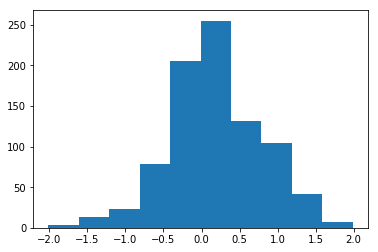

In [98]:
plt.hist(df_train["bias_score_after"])

The decrease is smaller than expected: perhaps more training is necessary?

In [99]:
df_train["original_bias_score"].abs().mean()

0.6061424133712771

In [100]:
df_train["bias_score_after"].abs().mean()

0.4928337284881208

In [101]:
df_val["bias_score_after"] = df_val.progress_apply(compute_bias_score, axis=1)

  0%|          | 0/96 [00:00<?, ?it/s]

  4%|▍         | 4/96 [00:00<00:03, 27.25it/s]

  7%|▋         | 7/96 [00:00<00:03, 24.79it/s]

 10%|█         | 10/96 [00:00<00:03, 23.25it/s]

 14%|█▎        | 13/96 [00:00<00:03, 22.23it/s]

 16%|█▌        | 15/96 [00:00<00:03, 21.13it/s]

 19%|█▉        | 18/96 [00:00<00:03, 20.67it/s]

 21%|██        | 20/96 [00:00<00:03, 19.47it/s]

 23%|██▎       | 22/96 [00:01<00:03, 19.38it/s]

 26%|██▌       | 25/96 [00:01<00:03, 19.67it/s]

 28%|██▊       | 27/96 [00:01<00:03, 19.15it/s]

 30%|███       | 29/96 [00:01<00:03, 18.74it/s]

 32%|███▏      | 31/96 [00:01<00:03, 18.42it/s]

 34%|███▍      | 33/96 [00:01<00:03, 18.29it/s]

 36%|███▋      | 35/96 [00:01<00:03, 18.17it/s]

 39%|███▊      | 37/96 [00:01<00:03, 18.18it/s]

 41%|████      | 39/96 [00:01<00:03, 18.14it/s]

 43%|████▎     | 41/96 [00:02<00:03, 18.01it/s]

 45%|████▍     | 43/96 [00:02<00:02, 18.11it/s]

 47%|████▋     | 45/96 [00:02<00:02, 18.14it/s]

 49%|████▉     | 47/96 [00:02<00:02, 18.30it/s]

 51%|█████     | 49/96 [00:02<00:02, 18.28it/s]

 53%|█████▎    | 51/96 [00:02<00:02, 18.55it/s]

 55%|█████▌    | 53/96 [00:02<00:02, 18.72it/s]

 57%|█████▋    | 55/96 [00:02<00:02, 18.76it/s]

 59%|█████▉    | 57/96 [00:02<00:02, 18.81it/s]

 61%|██████▏   | 59/96 [00:03<00:02, 18.44it/s]

 64%|██████▎   | 61/96 [00:03<00:01, 18.17it/s]

 66%|██████▌   | 63/96 [00:03<00:01, 18.28it/s]

 68%|██████▊   | 65/96 [00:03<00:01, 18.23it/s]

 70%|██████▉   | 67/96 [00:03<00:01, 18.11it/s]

 72%|███████▏  | 69/96 [00:03<00:01, 18.17it/s]

 74%|███████▍  | 71/96 [00:03<00:01, 17.92it/s]

 76%|███████▌  | 73/96 [00:03<00:01, 17.96it/s]

 78%|███████▊  | 75/96 [00:03<00:01, 17.98it/s]

 80%|████████  | 77/96 [00:04<00:01, 17.86it/s]

 82%|████████▏ | 79/96 [00:04<00:00, 18.18it/s]

 84%|████████▍ | 81/96 [00:04<00:00, 18.32it/s]

 86%|████████▋ | 83/96 [00:04<00:00, 18.27it/s]

 89%|████████▊ | 85/96 [00:04<00:00, 18.24it/s]

 91%|█████████ | 87/96 [00:04<00:00, 18.26it/s]

 93%|█████████▎| 89/96 [00:04<00:00, 18.33it/s]

 95%|█████████▍| 91/96 [00:04<00:00, 18.19it/s]

 97%|█████████▋| 93/96 [00:04<00:00, 18.23it/s]

 99%|█████████▉| 95/96 [00:05<00:00, 18.26it/s]

100%|██████████| 96/96 [00:05<00:00, 18.57it/s]

In [102]:
df_val["original_bias_score"].abs().mean()

0.5580325083186229

In [103]:
df_val["bias_score_after"].abs().mean()

0.4760621719372769

# Export Weights

As PyTorch state dict

In [104]:
torch.save(masked_lm.state_dict(), MODEL_SAVE_DIR / "state_dict.pth")

TODO: Export as tensorflow checkpoint?